In [1]:
import fenics as fn
import numpy as np
from matplotlib import pyplot as plt
#
from scipy.optimize import minimize
#
from time import time
import sys

In [2]:
print('Python version:',sys.version)

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


Example: Given a coarse trial espace $\mathbb{U}_n \leq \mathbb{V}$, solve using least square.
$$ u'(x) = \pi\sin(\pi x), \quad \text{in } (0,1],$$
$$ u(0) = 0,$$

Analytical sol:
$$u(x) = 1-\cos(\pi x)$$

**Initial setting**

In [3]:
# Number of elements coarse mesh (Un)
Ne_n = 2**4
# Number of elements fine mesh (Um)
Ne_m = 2**6 
# Number of neurons for hidden layer
Nn = 8
label_neurons = '_'+str(Nn)+'_neurons_'
# Boundary condition
u0 = 0.0
# Parameters
r = 10*Ne_n
alpha = 0.0
# RHS
f = fn.Constant(r)
# Epochs
EPOCHS = 500

**Bilinear form, RHS, and weighted inner-product**

In [4]:
#
def biliniear_form_func(un,wn,r, omega = fn.Constant(1.)):
    aux = omega*(un.dx(0) + fn.Constant(r)*un)*(wn.dx(0) + fn.Constant(r)*wn)*(fn.dx)
    return aux
# 
def rhs_func(f,wn,r, omega = fn.Constant(1.)):
    aux = omega*f*(wn.dx(0) + fn.Constant(r)*wn)*(fn.dx)
    return aux
#
#def weighted_inner_prod_func(omega,rm,vm):
#    aux = fn.dot(fn.grad(rm),fn.grad(vm))*(fn.dx)
#    return aux

**ANN definition, activation functions, and weight**

In [5]:
# Definition of ReLU function
def ReLU_func(z):   
    aux = z*(z>0)
    return aux
# Definition of sigmoid function (Fenics)
def Sigmoid_func(z):   
    aux = 1/ (1 + fn.exp(-z))
    return aux
# Definition of sigmoid function (Numpy)
def Sigmoid_func_num(z):   
    aux = 1/ (1 + np.exp(-z))
    return aux

# Definition of the ANN
def ANN_str(x,theta):
    # This function returns a string of the 
    # ANN function compatible with the command
    # 'Expression' of FEniCS
    Nnn = int(np.size(theta)/3)
    th1 = theta[0:Nnn]
    th2 = theta[Nnn:2*Nnn]
    th3 = theta[2*Nnn:]
    aux = 0
    for i in range(Nn):
        aux = aux + th3[i]*ReLU_func(th1[i]*x[0] + th2[i])
    net = aux
    return str(net)
# Definition of the ANN
def ANN_num(x,theta):
    # This function returns a number
    Nnn = int(np.size(theta)/3)
    th1 = theta[0:Nnn]
    th2 = theta[Nnn:2*Nnn]
    th3 = theta[2*Nnn:]
    aux = 0
    for i in range(Nn):
        aux = aux + th3[i]*ReLU_func(th1[i]*x + th2[i])
    net = aux
    return net
#
def alpha_op(x):
    return 1/2 + 2*Sigmoid_func_num(x)
#
def alpha_op_str(x,theta):
    # This function returns a string of the 
    # ANN function compatible with the command
    # 'Expression' of FEniCS
    Nnn = int(np.size(theta)/3)
    th1 = theta[0:Nnn]
    th2 = theta[Nnn:2*Nnn]
    th3 = theta[2*Nnn:]
    aux = 0
    for i in range(Nn):
        aux = aux + th3[i]*ReLU_func(th1[i]*x[0] + th2[i])
    net = aux
    return str(100*Sigmoid_func(net) + 1)

In [6]:
def least_square_FEM(u0,r,Ne = 32, poly_degree = 1):
    mesh = fn.IntervalMesh(Ne,0,1)
    Um = fn.FunctionSpace(mesh,'CG',poly_degree)
    # Boundary condition
    bc1 = fn.DirichletBC(Um,u0,'x[0]<DOLFIN_EPS')
    bc = bc1 #[bc1, bc2]
    
    um = fn.TrialFunction(Um)
    wm = fn.TestFunction(Um)
    
    bilinear_galerkin = biliniear_form_func(um,wm,r)
    l_galerkin = rhs_func(f,wm,r)
    
    A, L = fn.assemble_system(bilinear_galerkin,l_galerkin,bc)
    
    A_matrix = fn.as_backend_type(A).mat()
    AA = A_matrix[:,:]
    LL = L[:]
    
    um_sol = fn.Function(Um)
    coef = np.linalg.solve(AA,LL)
    
    um_sol.vector()[:] = coef
    return um_sol
None

**Discrete meshes**

[[0.    ]
 [0.0625]
 [0.125 ]
 [0.1875]
 [0.25  ]
 [0.3125]
 [0.375 ]
 [0.4375]
 [0.5   ]
 [0.5625]
 [0.625 ]
 [0.6875]
 [0.75  ]
 [0.8125]
 [0.875 ]
 [0.9375]
 [1.    ]]


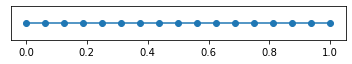

In [7]:
mesh_n = fn.IntervalMesh(Ne_n, 0,1)
Un = fn.FunctionSpace(mesh_n,'CG',1)
#
mesh_m = fn.IntervalMesh(Ne_m, 0,1)
Um = fn.FunctionSpace(mesh_m,'CG',1)
None
fn.plot(mesh_n)
print(mesh_n.coordinates()[:])

**Analytic solution**

In [8]:
def u_num(x,r):
    aux = 1 - np.exp(-r*x)
    return aux
u_fenics = fn.Expression('1 - exp(-r*x[0])',r=r, degree=2)

**Quantity of Interest**

In [9]:
#QoI location
xQoI = mesh_n.coordinates()[1][0]
# QoI function
def QoI_function(u):
    aux = u(xQoI)
    return aux
print(xQoI)
#
q_bar = u_num(xQoI,r)

0.0625


**Analytic neural network**

In [10]:
#def xi_num(x):
#    aux = -np.log(2/(np.sin(np.pi*x/2) + 1/2) - 1)
#    return aux

**Omega bar function** ($\bar\omega(x)$)

In [11]:
'''omega_bar_fenics = fn.Expression('1 + sin(pi*x[0]/2)', degree=2)
omega_bar_n = fn.Function(Un)
omega_bar_n.interpolate(omega_bar_fenics)
#
def omega_bar_num(x):
    aux = 1 + np.sin(np.pi*x/2)
    return aux'''
None

**Training set**

In [12]:
'''# Training values
X_train = [beta]
# Training labels
Y_train = []
for i in range(len(X_train)):
    Y_train.append(QoI_function(X_train[0],c,u0,xQoI))'''
None

In [13]:
'''print('Training set:',X_train)
print('Training set labels:',Y_train)'''
None

**Inital ANN's weights**

In [14]:
Np = 3*Nn # 3 times the number of neurons in the hidden layer
################################################
np.random.seed(42)
theta = np.random.uniform(-1,1,Np)  
################################################ MAKE THIS A FUNCTION!!
#theta = np.ones(Np)
##
#for j in range(Nn):
#    theta[Nn + j] = -(j-1)/(Nn-1)
##
#aux_matrix = np.zeros((Nn,Nn))
#for row in range(Nn):
#    for column in range(Nn):
#        aux_matrix[column,row] = 0. + (column >= row)*(1 + column -row)
#aux_matrix = aux_matrix/(Nn-1)
#aux_vector = xi_num(np.linspace(0,1,Nn))
#aux_c = np.linalg.solve(aux_matrix,aux_vector)
##
#theta[2*Nn:] = aux_c    
################################################
print(theta)
#theta = np.load('pesos_entrenados_500_iter.npy')

[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.88383278  0.73235229  0.20223002  0.41614516 -0.95883101  0.9398197
  0.66488528 -0.57532178 -0.63635007 -0.63319098 -0.39151551  0.04951286
 -0.13610996 -0.41754172  0.22370579 -0.72101228 -0.4157107  -0.26727631]


In [15]:
x_numpy = np.linspace(0,1,200)
#xi_numpy = xi_num(x_numpy)
#plt.plot(x_numpy,xi_numpy)

**Trial and test functions**

In [16]:
un = fn.TrialFunction(Un)
wn = fn.TestFunction(Un)

In [19]:
bc1 = fn.DirichletBC(Un,u0,'x[0]<DOLFIN_EPS')
bc = bc1 #[bc1, bc2]

#beta = X_train[0]
#
x = fn.SpatialCoordinate(mesh_n)

def cost_func(theta,alpha=0.0):
    omega = fn.Expression(alpha_op_str(x,theta),degree=2)
    #
    bilinear_galerkin =biliniear_form_func(un,wn,r, omega = omega)
    l_galerkin = rhs_func(f,wn,r, omega = omega)
    #
    A, L = fn.assemble_system(bilinear_galerkin,l_galerkin,bc)
    #
    A_matrix = fn.as_backend_type(A).mat()
    AA = A_matrix[:,:]
    LL = L[:]
    #
    un_sol = fn.Function(Un)
    coef = np.linalg.solve(AA,LL)
    #
    un_sol.vector()[:] = coef
    ####################################################################
    #xi_fenics = fn.Expression(ANN_str(x,theta),degree=2)
    #xi_n = fn.Function(Um)
    #xi_n.interpolate(xi_fenics)
    #xi_n_norm_square = fn.assemble(xi_n**2*(fn.dx))
    ####################################################################
    QoI_un = QoI_function(un_sol)
    ####################################################################
    J1 = (1/2)*(QoI_un - q_bar)**2 #+ #alpha*xi_n_norm_square
    ####################################################################
    J = J1 #np.dot(np.array(omega_bar_list),np.array(element_integration))/2 # plus reg term!!
    J_vector.append(J)
    print(J)
    return J

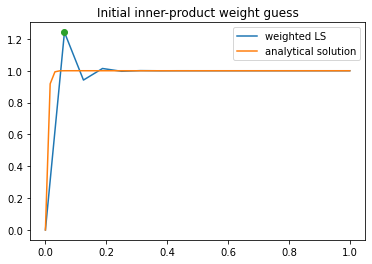

In [30]:
omega = fn.Expression(alpha_op_str(x,theta),degree=2)
#
bilinear_galerkin = biliniear_form_func(un,wn,r, omega = omega)
l_galerkin = rhs_func(f,wn,r, omega = omega)
#
A, L = fn.assemble_system(bilinear_galerkin,l_galerkin,bc)
#
A_matrix = fn.as_backend_type(A).mat()
AA = A_matrix[:,:]
LL = L[:]
#
u0_sol = fn.Function(Un)
coef = np.linalg.solve(AA,LL)
#
u0_sol.vector()[:] = coef
#
fn.plot(u0_sol, label='weighted LS')
u_fenics_m = fn.Function(Um)
u_fenics_m.interpolate(u_fenics)
fn.plot(u_fenics_m, label='analytical solution')
plt.plot([xQoI],[u0_sol(xQoI)],'o')
#
plt.legend()
plt.title('Initial inner-product weight guess')
plt.show()

0.029259689182530007
0.029254523181868927
0.029257341926718198
0.029259689182530007
0.029264023005270316
0.029267785786419736
0.029259689182530007
0.029259689182530007
0.029259689182530007
0.029259848585985505
0.02925964767764351
0.029259689182530007
0.029260477864386285
0.029259389365210844
0.029259689182530007
0.029259689182530007
0.029259689182530007
0.029254674188196477
0.029257301415231123
0.029259689182530007
0.02926484653633974
0.02926746121957352
0.029259689182530007
0.029259689182530007
0.029259689182530007
0.029251799736456773
0.029243749290501244
0.029250197704977342
0.029251651808855215
0.029251393327865395
0.02925420822595055
0.029254338596903063
0.029254045841547966
0.029253576568321664
0.029253068363131268
0.029252518011777445
0.02925192203741411
0.029251276679557618
0.02925057787149968
0.029249821216016898
0.029249001959268398
0.02924811496276115
0.02924715467326833
0.029246115090575533
0.029244989732931367
0.02924381018375139
0.029242723777051748
0.029234382399389015
0

0.02831811196136676
0.028298839759470604
0.028254836710804483
0.02831625593253395
0.028297720186276774
0.028300081449397184
0.028289803519532256
0.028276779688435966
0.028292429921692713
0.02827894304553682
0.028282284126350338
0.02826258797055077
0.0282548437877084
0.028261920640465805
0.028278597556573675
0.028250409220138887
0.028218918543647286
0.028253251388656843
0.0282320515151917
0.02822291877358188
0.028216437149474003
0.02816938982241501
0.028215440679560673
0.02822122249761567
0.028223861668101823
0.028210828289123684
0.028211798417858425
0.028174722496182716
0.02817110095395279
0.028171481692587246
0.02818343705658068
0.028168965594985076
0.028108783566092053
0.02815560338742623
0.028153754652583077
0.028149312841252307
0.02813682122119001
0.028154036046323307
0.028099484751138066
0.02801568540773951
0.028098121582773715
0.028105159182284824
0.028086800447583517
0.028072039881977928
0.028087900575534848
0.028070774514991136
0.028082625120213985
0.02803517593710432
0.0280479

0.003009397727098656
0.0030942454286800106
0.00329659333761247
0.004080091265343897
0.0026298418452658265
0.0017861703306233155
0.0026298274878465058
0.0033066017903113864
0.002539972117557239
0.003008440377150351
0.0022595544099330025
0.0028200200391184293
0.002007804594542745
0.0020707821316077596
0.0019381269525568308
0.001885465425589879
0.0031043404673952286
0.001816202435440512
0.002324098043790441
0.001879972752288106
0.001780349531489385
0.0016021173753152066
0.0017245073547363311
0.0013980549868528006
0.0008410654638661021
0.0012368365296885758
0.0012504699757473895
0.001133219531600544
0.001587875385479966
0.0016213846702140715
0.0016634911385137224
0.0009278427355361159
0.000841818712819584
0.0010035930902770039
0.0010791419035834535
0.001000774929217339
0.0006776006040864004
0.00038436675419604175
0.0006395530715783182
0.0009070382812615468
0.0005553191242743517
0.0006080975980864984
0.0005078804591536892
0.0005164001014505823
0.0005007960732970627
0.0005979376248446839
0.0

1.6143384862564446e-11
1.850408996326542e-12
9.426419713721422e-12
3.0158266124139584e-12
7.082950770819884e-12
1.04061153388466e-11
2.3270676454522143e-12
4.804504783007173e-11
3.061709073745617e-12
7.466214855336464e-12
1.6781345848829214e-12
7.627452112924545e-12
1.3592866271792053e-12
4.99587237363142e-12
1.3487098000928358e-12
5.689793463762669e-12
8.963620621267032e-13
5.597727065598076e-12
7.669990763553368e-13
3.4363864570003904e-12
5.799455142805323e-12
9.597578318943282e-13
7.909734673740724e-12
9.486412907686383e-13
3.0347332353483665e-12
4.33153175507622e-12
6.94755050930633e-13
3.4342369961582614e-12
9.108687153855382e-13
5.288923045087974e-12
9.463830957486261e-13
3.944308228291809e-12
7.118437054933224e-13
7.448898511025408e-12
9.68184731254724e-13
3.717373933175353e-12
7.519619376367149e-13
3.972534324477276e-12
7.138066514987004e-13
3.05678538619746e-12
6.948594352978009e-13
2.52576269533455e-12
5.564484039899615e-13
2.826055778363415e-12
5.111915917473183e-13
3.106008

8.090895506235056e-17
1.4950975362792987e-17
8.217640005177551e-17
1.3442514804614413e-17
5.918182741293655e-17
7.902289385725848e-17
1.3117923324841433e-17
5.681427198226261e-17
7.704140942785459e-17
1.2637103821191669e-17
5.402894816834437e-17
7.237865663938556e-17
1.2036039801852462e-17
5.190946885407402e-17
5.62591040534486e-17
1.3194107569494386e-17
5.86710387356556e-17
1.2170474931675546e-17
5.80286322519872e-17
1.2025832427718555e-17
5.549332753636208e-17
1.152225354883143e-17
5.144452962137914e-17
9.415737964364942e-18
3.712485498640469e-17
8.705961729151215e-18
4.057587554597235e-17
7.330026663969615e-18
4.261113253129797e-17
6.652407432024631e-18
2.8879630146610544e-17
6.893536614239622e-18
3.284294085601774e-17
6.3794049234735165e-18
3.056553674857315e-17
5.210308026310828e-18
2.1520427765684334e-17
5.2984211961181334e-18
2.552308387065678e-17
4.6194714169442835e-18
2.0612220026816542e-17
4.98434413256401e-18
2.1682101597436634e-17
4.634698633611991e-18
2.3141604262673386e-1

2.228696197731927e-21
3.6237068498023734e-22
1.6009162247987528e-21
3.8940060457994287e-22
1.5948596720135806e-21
3.2604977129095025e-22
1.702360754329877e-21
3.0686356165883936e-22
1.7565539701005567e-21
2.7808475695656625e-22
1.1874102200196159e-21
1.3863909838127595e-21
3.0740012651171762e-22
1.4278887477346785e-21
2.797157029657645e-22
1.507594827514713e-21
2.603932078747749e-22
1.5958756180181564e-21
2.425709422175465e-22
9.695209633504112e-22
1.1479238662948687e-21
2.408987554538548e-22
1.1440385069408789e-21
2.363849788161659e-22
1.0862224674310134e-21
2.283364379097832e-22
1.0773763021759395e-21
2.2234059232849165e-22
1.058428187164703e-21
2.2243893271501263e-22
1.0041143246033896e-21
2.074330613246033e-22
9.919322318033549e-22
1.804266293804234e-22
9.428092548262693e-22
1.4929458972935964e-22
9.162140236608913e-22
1.2542987568237314e-22
9.402558559199246e-22
1.11878045500642e-22
9.048670960091805e-22
9.074740941005453e-23
9.612764637683747e-22
8.414447343661436e-23
2.734385770

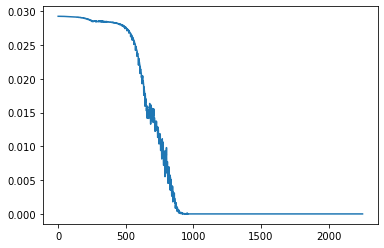

In [24]:
start_time = time()
#
J_vector = []
argmin_th = minimize(cost_func, theta, args=(alpha), method='Nelder-Mead',
                      options={'xatol':1e-7,'fatol':1e-7,'maxiter': 1500, 'disp':True})
#
print('Cost function',argmin_th.fun)
print('Computing time:',(time() - start_time)/60,'minutes')

'''

'''
plt.plot(J_vector)
None

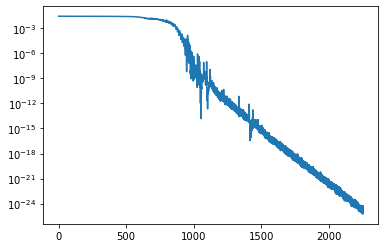

In [25]:
plt.semilogy(J_vector)
np.save('Data/loss_3.1.3_omega_alpha_0',J_vector)

In [26]:
th_opt = argmin_th.x

In [27]:
#np.save('pesos_Example_3.1.3-with_bias_16_neurons',argmin_th.x)

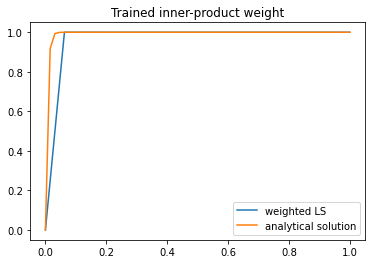

In [28]:
omega = fn.Expression(alpha_op_str(x,th_opt),degree=2)
#
bilinear_galerkin = biliniear_form_func(un,wn,r, omega = omega)
l_galerkin = rhs_func(f,wn,r, omega = omega)
#
A, L = fn.assemble_system(bilinear_galerkin,l_galerkin,bc)
#
A_matrix = fn.as_backend_type(A).mat()
AA = A_matrix[:,:]
LL = L[:]
#
un_sol = fn.Function(Un)
coef = np.linalg.solve(AA,LL)
#
un_sol.vector()[:] = coef
#
fn.plot(un_sol, label='weighted LS')
u_fenics_m = fn.Function(Um)
u_fenics_m.interpolate(u_fenics)
fn.plot(u_fenics_m, label='analytical solution')
#
plt.legend()
plt.title('Trained inner-product weight')
plt.show()

In [29]:
x_vector = np.linspace(0,1,2**8+1)
y_vector = np.zeros(x_vector.shape)
for i in range(len(x_vector)):
    y_vector[i] = un_sol(x_vector[i])
np.savez('Data/solution_3.1.3_omega_alpha_0', x = x_vector, y = y_vector)

(0.0, 1.0)

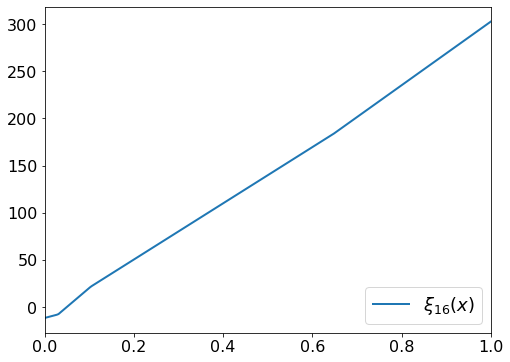

In [35]:
plt.figure(figsize=(8,6))
ANN_numpy = ANN_num(x_vector,th_opt)
plt.plot(x_vector, ANN_numpy,
         label=r'$\xi_{16}(x)$',
         linewidth=2.0)
#
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=18, loc='lower right')
#
plt.xlim(0,1)
#plt.ylim(-2,3)
#
#plt.show()
#plt.savefig('Images/xi_16_new_cost.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, 
#            bbox_inches='tight', pad_inches=0.1, metadata=None)

In [ ]:
print(format(np.linalg.norm(ANN_numpy - xi_numpy),'.3e'))
# 0.0808291629094569

In [ ]:
omega_bar_numpy = omega_bar_num(x_numpy)
omega = fn.Expression(alpha_op_str(x,th_opt),degree=2)
omega_m = fn.Function(Um)
omega_m.interpolate(omega)
#
plt.figure(figsize=(8,6))
fn.plot(omega_m,
         label=r'$\omega(\xi_{16}(x))$',
         linewidth=2.0)
plt.plot(x_numpy,omega_bar_numpy,
         label=r'$\bar\omega(x)$',
         linestyle='--',
         linewidth=2.0)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=18, loc='lower right')
#
plt.xlim(0,1)
plt.ylim(0.8,2.5)
#
plt.savefig('Images/omega_xi_16_new_cost.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, 
            bbox_inches='tight', pad_inches=0.1, metadata=None)

In [ ]:
u_numpy = u_num(x_numpy)

plt.figure(figsize=(8,6))
fn.plot(un_sol,
         label=r'$S_h(\xi_{16}(x))$',
         linewidth=2.0)
plt.plot(x_numpy,u_numpy,
         label=r'$u(x)$',
         linestyle='--',
         linewidth=2.0)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=18, loc='lower right')
#
plt.xlim(0,1)
#plt.ylim(0.8,2.5)
#
plt.savefig('Images/u_sol_xi_16_new_cost.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, 
            bbox_inches='tight', pad_inches=0.1, metadata=None)

**Save the data**

In [34]:
# Save xi_n
np.savez('Data/xi_3.1.3_omega_alpha_0',x=x_vector,ANN=ANN_numpy)

In [ ]:
# Save omega
omega_xi_n_numpy = np.zeros(x_numpy.shape)
for i in range(len(x_numpy)):
    omega_xi_n_numpy[i] = omega(x_numpy[i])
#    
np.savez('Data/omega_n_data'+label_neurons,x=x_numpy,omega=omega_xi_n_numpy)

In [ ]:
# Save un
S_h_numpy = np.zeros(x_numpy.shape)
for i in range(len(x_numpy)):
    S_h_numpy[i] = un_sol(x_numpy[i])
#    
np.savez('Data/un_data'+label_neurons,x=x_numpy,un=S_h_numpy)

In [36]:
un_lsq = least_square_FEM(u0,r,Ne = 8, poly_degree = 1)

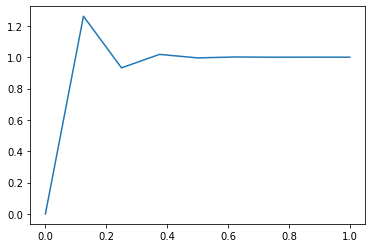

In [37]:
fn.plot(un_lsq)

In [38]:
x_vector = np.linspace(0,1,2**8+1)
y_vector = np.zeros(x_vector.shape)
for i in range(len(x_vector)):
    y_vector[i] = un_lsq(x_vector[i])
np.savez('Data/solution_3.1.3_LSQ', x = x_vector, y = y_vector)    